TensorFlow version: 2.9.1
TFDS version: 4.9.9+nightly


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Jason Eckert\tensorflow_datasets\oxford_flowers102\incomplete.3IJL30_2.1.1\oxford_flowers10…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Jason Eckert\tensorflow_datasets\oxford_flowers102\incomplete.3IJL30_2.1.1\oxford_flowers10…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Jason Eckert\tensorflow_datasets\oxford_flowers102\incomplete.3IJL30_2.1.1\oxford_flowers10…

Dataset oxford_flowers102 downloaded and prepared to C:\Users\Jason Eckert\tensorflow_datasets\oxford_flowers102\2.1.1. Subsequent calls will reuse this data.
Number of classes: 102
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 256)       614656    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 384)       885120    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 384)      0         
 2D)

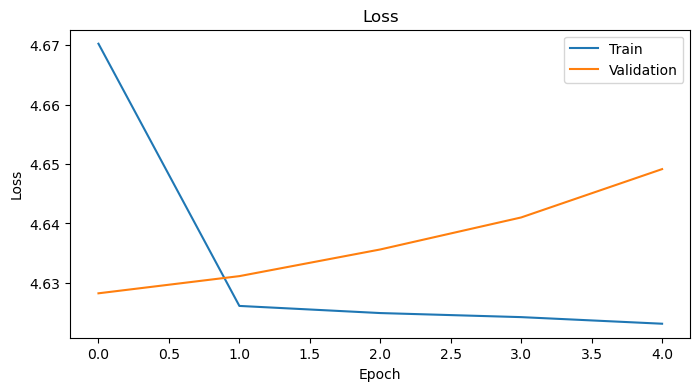

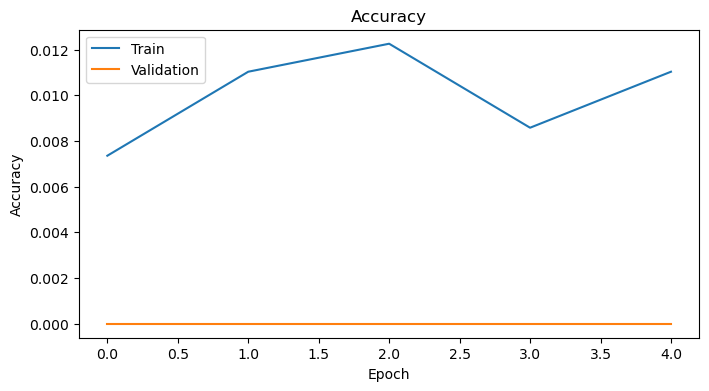

1/1 [==============================] - 0s 189ms/step


C:\Users\Jason Eckert\AppData\Local\Temp\ipykernel_14196\2025966103.py:148: RuntimeWarning: invalid value encountered in divide
  cmat_norm = (cmat.T / cmat.sum(axis=1)).T
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


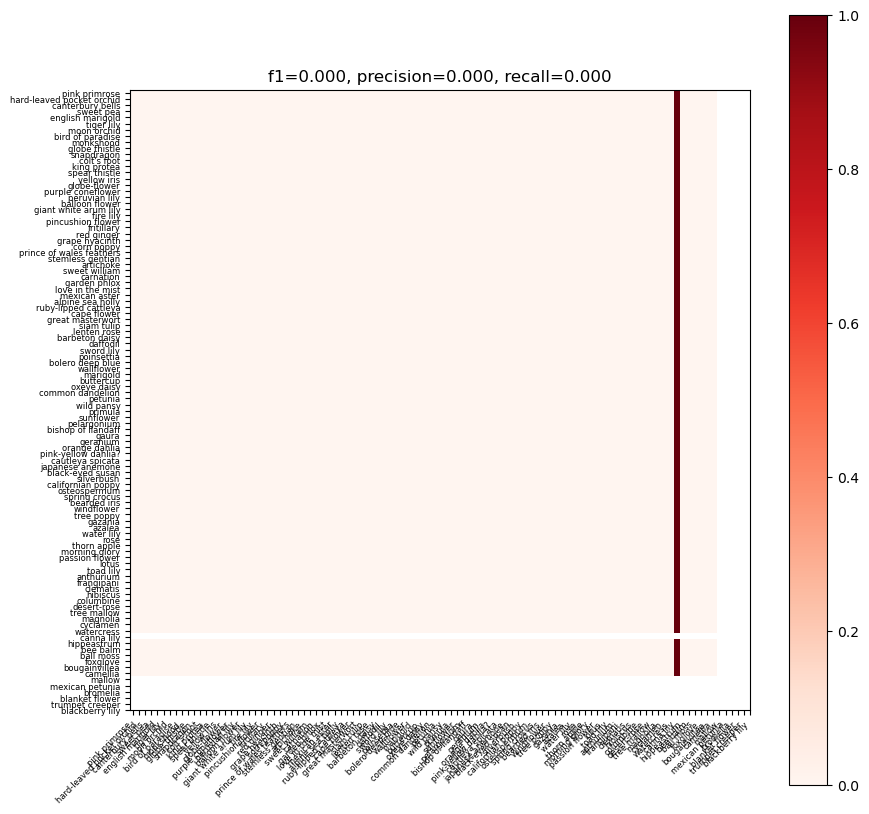

1/1 [==============================] - 0s 145ms/step


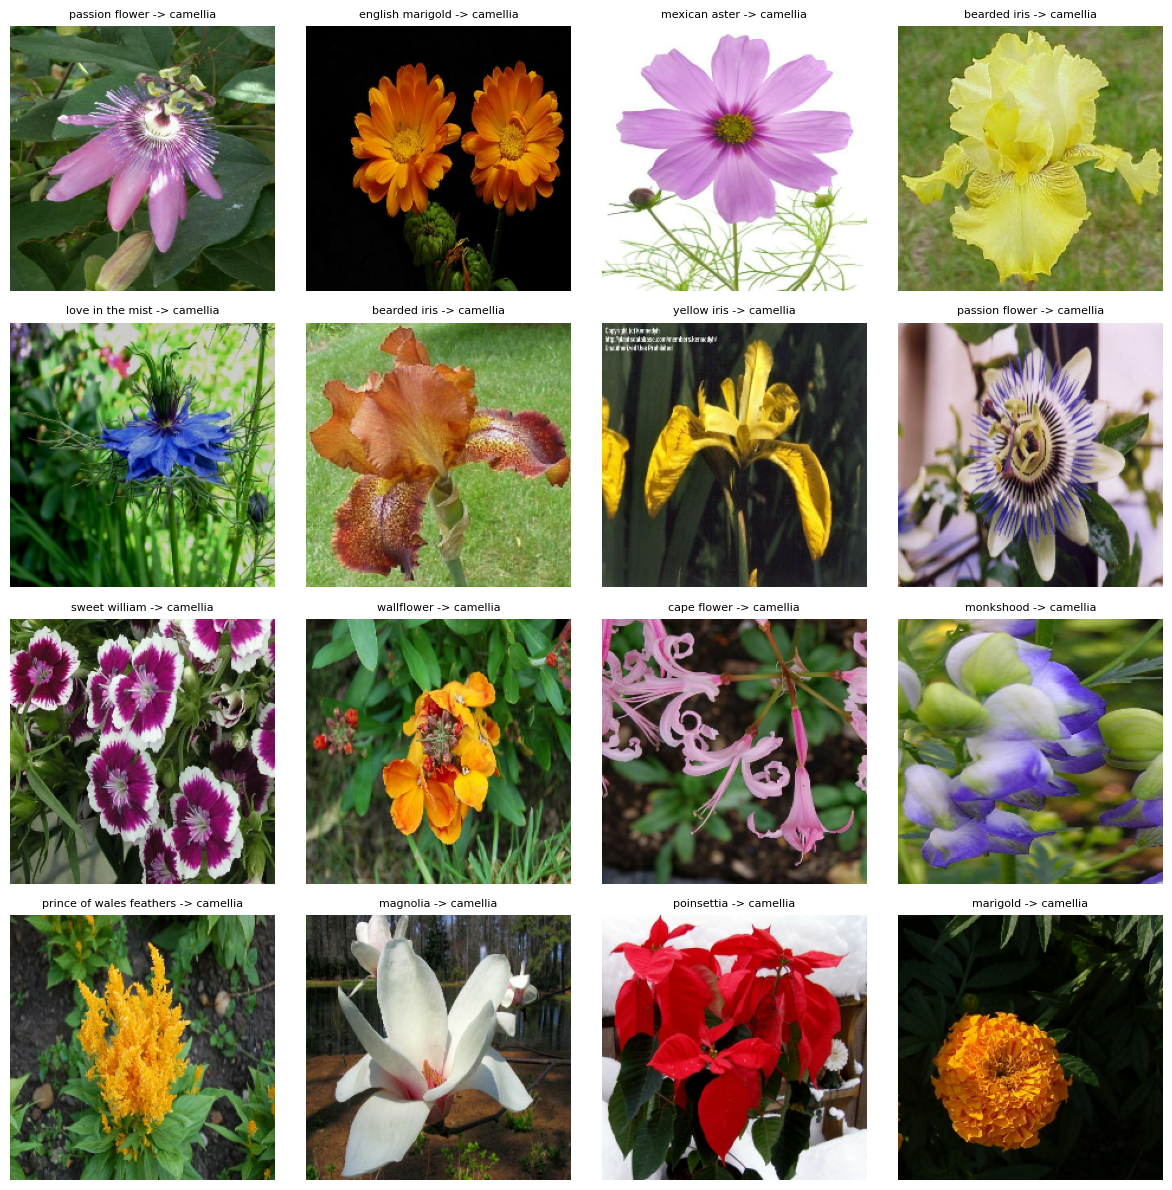

In [2]:
# ============================================================
# 03c_fromzero_ALEXNET_flowers102_tfds.ipynb
# Train a hand-crafted AlexNet on Flowers102 using TFDS
# ============================================================

# 1. Imports
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("TensorFlow version:", tf.__version__)
print("TFDS version:", tfds.__version__)

# -----------------------------
# 2. Settings
# -----------------------------
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 16
EPOCHS = 5

# -----------------------------
# 3. Load dataset from TFDS
# -----------------------------
(ds_train, ds_val), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:]'],   # approximate train/val split
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)

NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names
print(f"Number of classes: {NUM_CLASSES}")

# -----------------------------
# 4. Dataset preprocessing
# -----------------------------
def preprocess(image, label, augment=False):
    # Resize to IMAGE_SIZE
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    image /= 255.0  # normalize to [0,1]

    if augment:
        image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_dataset(ds, batch_size, augment=False, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.map(lambda x,y: preprocess(x,y,augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(ds_train, BATCH_SIZE, augment=True, shuffle=True)
val_dataset = prepare_dataset(ds_val, BATCH_SIZE)

# -----------------------------
# 5. Helper functions for visualization
# -----------------------------
def display_batch_of_images(images, labels, predictions=None):
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    plt.figure(figsize=(12,12))
    for i,(img,label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        plt.imshow(img)
        title = CLASS_NAMES[label]
        if predictions is not None:
            title += f" -> {CLASS_NAMES[predictions[i]]}" if predictions[i]!=label else ""
        plt.title(title, fontsize=8)
    plt.tight_layout()
    plt.show()

def display_training_curves(train, val, metric):
    plt.figure(figsize=(8,4))
    plt.plot(train)
    plt.plot(val)
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(['Train', 'Validation'])
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(10,10))
    plt.imshow(cmat, cmap='Reds')
    plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=45, ha='right', fontsize=6)
    plt.yticks(range(NUM_CLASSES), CLASS_NAMES, fontsize=6)
    plt.colorbar()
    plt.title(f"f1={score:.3f}, precision={precision:.3f}, recall={recall:.3f}")
    plt.show()

# -----------------------------
# 6. Build AlexNet
# -----------------------------
model = tf.keras.Sequential([
    tf.keras.Input(shape=[*IMAGE_SIZE,3]),
    tf.keras.layers.Conv2D(96,11,strides=4,activation='relu'),
    tf.keras.layers.Conv2D(256,5,activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(384,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(384,3,activation='relu'),
    tf.keras.layers.Conv2D(256,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

# -----------------------------
# 7. Train
# -----------------------------
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# -----------------------------
# 8. Plot training curves
# -----------------------------
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss')
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'Accuracy')

# -----------------------------
# 9. Confusion matrix & metrics
# -----------------------------
all_labels = np.concatenate([y.numpy() for x,y in val_dataset], axis=0)
all_preds = np.concatenate([np.argmax(model.predict(x), axis=-1) for x,y in val_dataset], axis=0)

cmat = confusion_matrix(all_labels, all_preds)
cmat_norm = (cmat.T / cmat.sum(axis=1)).T

score = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

display_confusion_matrix(cmat_norm, score, precision, recall)

# -----------------------------
# 10. Display some predictions
# -----------------------------
for images, labels in val_dataset.take(1):
    predictions = np.argmax(model.predict(images), axis=-1)
    display_batch_of_images(images.numpy(), labels.numpy(), predictions)


# Fast Version - Key Optimizations:
- Image size: 128×128 → smaller and faster.
- Convolution filters: 32→64→128 instead of 96→384 → fewer computations.
- Dense layers: 512→256 → much smaller memory footprint.
- Subset dataset: 1k train / 200 val → fast demo.
- Epochs: 3 → under 5 minutes on CPU, ~1-2 min on small GPU.
- Everything else is identical pedagogically: training curves, metrics, confusion matrix, sample predictions.

TensorFlow version: 2.9.1
TFDS version: 4.9.9+nightly
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        11648     
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 


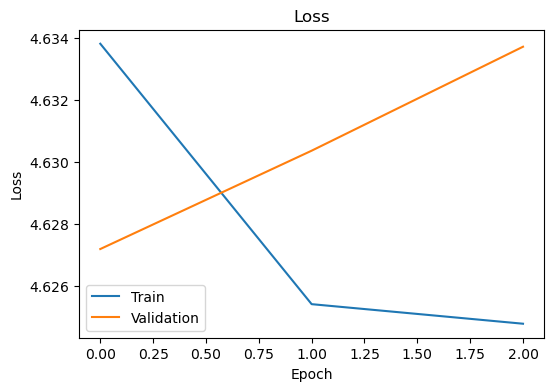

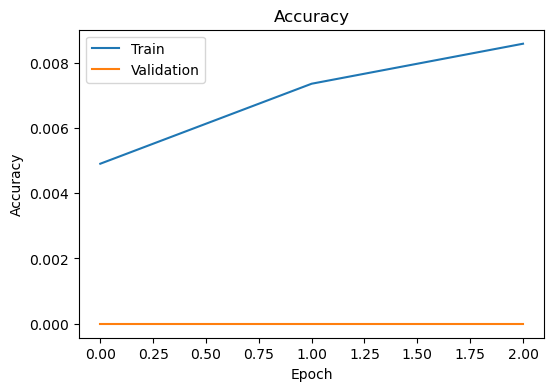

1/1 [==============================] - 0s 24ms/step


C:\Users\Jason Eckert\AppData\Local\Temp\ipykernel_14196\3962582579.py:136: RuntimeWarning: invalid value encountered in divide
  cmat_norm = (cmat.T / cmat.sum(axis=1)).T
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


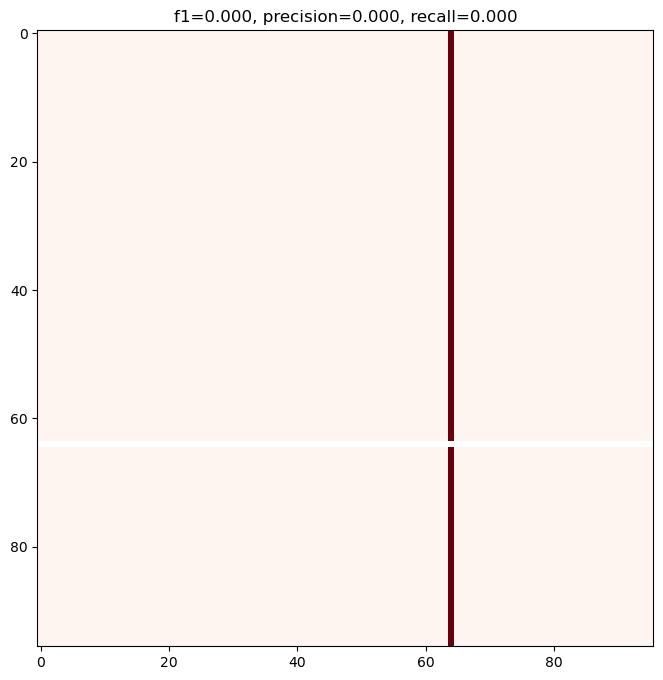

1/1 [==============================] - 0s 27ms/step


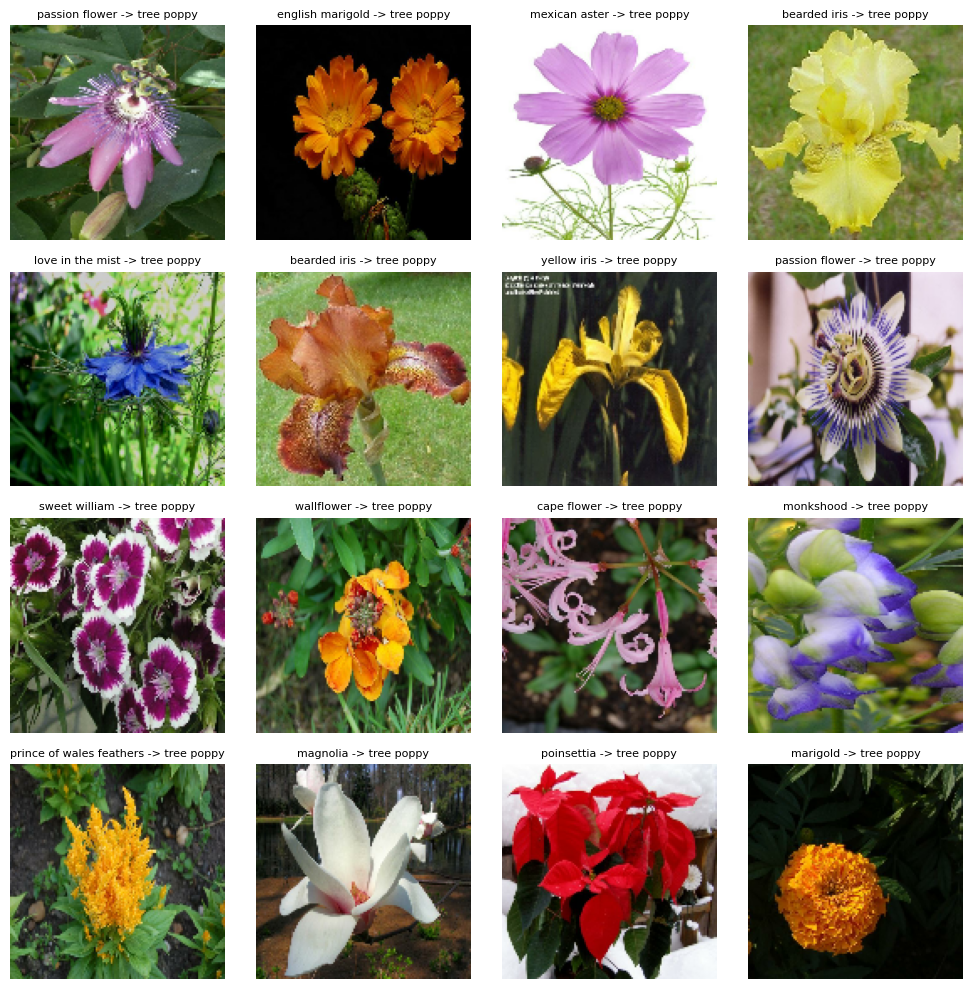

In [3]:
# ============================================================
# 03c_fromzero_ALEXNET_flowers102_fast.ipynb
# Quick BYOD-friendly AlexNet demo on Flowers102
# ============================================================

import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("TensorFlow version:", tf.__version__)
print("TFDS version:", tfds.__version__)

# -----------------------------
# 1. Settings
# -----------------------------
IMAGE_SIZE = [128,128]   # smaller images = faster
BATCH_SIZE = 16
EPOCHS = 3               # demo-friendly
NUM_TRAIN_SUBSET = 1000  # only use 1000 training images
NUM_VAL_SUBSET = 200     # only 200 validation images

# -----------------------------
# 2. Load TFDS dataset
# -----------------------------
(ds_train_full, ds_val_full), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names

# -----------------------------
# 3. Dataset preprocessing
# -----------------------------
def preprocess(image, label, augment=False):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)/255.0
    if augment:
        image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_dataset(ds, batch_size, augment=False, shuffle=False, subset=None):
    if subset:
        ds = ds.take(subset)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.map(lambda x,y: preprocess(x,y,augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(ds_train_full, BATCH_SIZE, augment=True, shuffle=True, subset=NUM_TRAIN_SUBSET)
val_dataset = prepare_dataset(ds_val_full, BATCH_SIZE, subset=NUM_VAL_SUBSET)

# -----------------------------
# 4. Helper functions for visualization
# -----------------------------
def display_batch_of_images(images, labels, predictions=None):
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    plt.figure(figsize=(10,10))
    for i,(img,label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        plt.imshow(img)
        title = CLASS_NAMES[label]
        if predictions is not None and predictions[i]!=label:
            title += f" -> {CLASS_NAMES[predictions[i]]}"
        plt.title(title, fontsize=8)
    plt.tight_layout()
    plt.show()

def display_training_curves(train, val, metric):
    plt.figure(figsize=(6,4))
    plt.plot(train)
    plt.plot(val)
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(['Train', 'Validation'])
    plt.show()

# -----------------------------
# 5. Build a smaller AlexNet
# -----------------------------
model = tf.keras.Sequential([
    tf.keras.Input(shape=[*IMAGE_SIZE,3]),
    tf.keras.layers.Conv2D(32,11,strides=4,activation='relu'),
    tf.keras.layers.Conv2D(64,5,activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

# -----------------------------
# 6. Train
# -----------------------------
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# -----------------------------
# 7. Training curves
# -----------------------------
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss')
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'Accuracy')

# -----------------------------
# 8. Confusion matrix & metrics
# -----------------------------
all_labels = np.concatenate([y.numpy() for x,y in val_dataset], axis=0)
all_preds = np.concatenate([np.argmax(model.predict(x), axis=-1) for x,y in val_dataset], axis=0)

cmat = confusion_matrix(all_labels, all_preds)
cmat_norm = (cmat.T / cmat.sum(axis=1)).T

score = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

plt.figure(figsize=(8,8))
plt.imshow(cmat_norm, cmap='Reds')
plt.title(f"f1={score:.3f}, precision={precision:.3f}, recall={recall:.3f}")
plt.show()

# -----------------------------
# 9. Display some predictions
# -----------------------------
for images, labels in val_dataset.take(1):
    predictions = np.argmax(model.predict(images), axis=-1)
    display_batch_of_images(images.numpy(), labels.numpy(), predictions)
